In [1]:
%load_ext bigquery_magics

# "Will it snow tomorrow?" - The time traveler asked
The following dataset contains climate information from over 9000 stations accross the world. The overall goal of these subtasks will be to predict whether it will snow tomorrow 20 years ago. So if today is 1 April 2025 then the weather we want to forecast is for the 2 April 2005. You are supposed to solve the tasks using Big Query, which can be used in the Jupyter Notebook like it is shown in the following cell. For further information and how to use BigQuery in Jupyter Notebook refer to the Google Docs. 

The goal of this test is to test your coding knowledge in Python, BigQuery and Pandas as well as your understanding of Data Science. If you get stuck in the first part, you can use the replacement data provided in the second part.

In [2]:
%%bigquery
SELECT
*,
FROM `bigquery-public-data.samples.gsod`
LIMIT 20 


Query is running:   0%|          |

Downloading:   0%|          |

,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,min_temperature,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado
0,39800,99999,1929,11,13,41.299999,4,37.000000,4,996.700012,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False
1,33110,99999,1929,12,16,45.500000,4,34.500000,4,1037.000000,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
2,37770,99999,1929,12,8,48.000000,4,42.000000,4,994.500000,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False
3,38560,99999,1929,11,13,44.500000,4,36.200001,4,997.799988,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False
4,33110,99999,1929,12,15,46.700001,4,42.500000,4,1028.099976,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
5,30910,99999,1929,10,6,50.000000,4,NaN,<NA>,983.200012,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False
6,33110,99999,1929,10,1,53.299999,4,46.299999,4,1010.000000,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False
7,39730,99999,1929,11,4,54.000000,4,48.700001,4,1019.299988,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False
8,38110,99999,1929,11,18,43.500000,4,39.500000,4,1016.299988,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False
9,39530,99999,1929,10,23,54.000000,4,50.000000,4,1001.099976,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False


## Part 1

### 1. Task
Change the date format to 'YYYY-MM-DD' and select the data from 2000 till 2005 for station numbers including and between 725300 and 726300 , and save it as a pandas dataframe. Note the maximum year available is 2010. 

There is no prespecified date column, therefore we create a new one from the year, month and day columns and save it to `df`.


In [3]:
%%bigquery df
SELECT *, DATE(year, month, day) AS date
FROM `bigquery-public-data.samples.gsod`
WHERE (year BETWEEN 2000 AND 2005) AND (station_number BETWEEN 725300 AND 726300)


Query is running:   0%|          |

Downloading:   0%|          |

In [4]:
# check that df is a pandas dataframe
type(df)

pandas.core.frame.DataFrame

### 2. Task 
From here you want to work with the data from all stations 725300 to 725330 that have information from 2000 till 2005. 

In [5]:
# Since data fits in memory, we use pandas for the tasks.
# df contains only columns >= 725300 with the required years, hence only filter upper column bound
df_small = df[(df.station_number <= 725330)]

----------

Start by checking which year received the most snowfall in our data. 

"Most snowfall" can be defined in several ways, e.g.:
- most days with snow
- total snow accumulation

In my view, most snow accumulation would be most accurate, however `snow_depth` does not account for snow that has melted on the same day. Therefore we calculate the most days with snow.

In [6]:
snow_by_year = df_small.groupby('year')['snow'].sum().reset_index().rename(columns={'snow': 'no_days_with_snow'})
snow_by_year.sort_values(by='no_days_with_snow', ascending=False)

,year,no_days_with_snow
5,2005,826
0,2000,797
1,2001,759
2,2002,745
3,2003,555
4,2004,262


The year with the highest number of days on which it snowed is 2005. We still need to check if the data is complete for each year.

In [7]:
# check if number of stations stays the same for each year
df_small.groupby('year')['station_number'].nunique().reset_index().rename(columns={'station_number': 'no_stations'})

,year,no_stations
0,2000,10
1,2001,10
2,2002,10
3,2003,10
4,2004,10
5,2005,10


In [8]:
df_small['station_number'].nunique() 

10

The dataset contains data for 10 stations and for each station we have data for all six year.

In [9]:
# check if all days have been recorded for each station
entries_per_year_and_station = df_small.groupby(['station_number', 'year'])['date'].count().reset_index().rename(columns={'date': 'no_entries'})
entries_per_year_and_station[entries_per_year_and_station.no_entries != 365]

,station_number,year,no_entries
0,725300,2000,366
4,725300,2004,366
6,725305,2000,366
7,725305,2001,363
12,725314,2000,366
13,725314,2001,364
16,725314,2004,366
17,725314,2005,350
18,725315,2000,366
22,725315,2004,366


The entries with 366 days are due to leap years. Still there are a coupleof station-year combinations with incomplete data. So instead of the absolute number of days with snow we compute the percentage.

In [10]:
entries_by_year = df_small.groupby('year')['snow'].count().reset_index().rename(columns={'snow':'no_entries'})
snow_by_year = snow_by_year.merge(entries_by_year, on='year')
snow_by_year['snowfall_percent'] = 100 * snow_by_year['no_days_with_snow'] / snow_by_year['no_entries']
snow_by_year.sort_values(by='snowfall_percent', ascending=False)

,year,no_days_with_snow,no_entries,snowfall_percent
5,2005,826,3627,22.773642
0,2000,797,3647,21.853578
1,2001,759,3641,20.845921
2,2002,745,3644,20.444566
3,2003,555,3643,15.234697
4,2004,262,3651,7.176116


We still end up with the same year, 2005, in which it snowed on 22.77 % of the recorded days across stations.

-------------------------

Add an additional field that indicates the daily change in snow depth measured at every station. And identify the station and day for which the snow depth increased the most.  

In [11]:
import pandas as pd

In [12]:
# convert to datetime for operations
df_small.date = pd.to_datetime(df_small.date).dt.date

/var/folders/kw/8qnvzy413f1dk3_stsfvqjgm0000gn/T/ipykernel_23617/954408811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small.date = pd.to_datetime(df_small.date).dt.date


In [13]:
# create a new dataframe which contains only snow depth for recorded days
snow_depth = df_small[['snow_depth', 'station_number', 'date']]

In [14]:
# increment date column by one day s.t. snow_depth contains the the snow depth for previous day
snow_depth['date'] += pd.Timedelta('1 days')
snow_depth = snow_depth.rename(columns={'snow_depth': 'snow_depth_previous_day'})

/var/folders/kw/8qnvzy413f1dk3_stsfvqjgm0000gn/T/ipykernel_23617/2796780097.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snow_depth['date'] += pd.Timedelta('1 days')


In [15]:
snow_depth.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21853 entries, 88 to 447032
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   snow_depth_previous_day  868 non-null    float64
 1   station_number           21853 non-null  Int64  
 2   date                     21853 non-null  object 
dtypes: Int64(1), float64(1), object(1)
memory usage: 704.2+ KB


In [16]:
# There are many NA values for snow_depth. We drop NAs since they do not contain information and slow down merge/join
snow_depth = snow_depth[~snow_depth['snow_depth_previous_day'].isna()]

In [17]:
# include the snow at previous date in the original dataframe
df_small = df_small.merge(snow_depth, how='left', on=['station_number', 'date'])

In [18]:
# calculate daily change
df_small['snow_depth_daily_change'] = df_small['snow_depth'] - df_small['snow_depth_previous_day']

In [19]:
# Drop NA before sorting for speed up
snow_depth_change = df_small[['station_number', 'date', 'snow_depth_daily_change']].dropna(how='any')
snow_depth_change_sorted = snow_depth_change.sort_values(by='snow_depth_daily_change', ascending=False)
snow_depth_change_sorted.head()

,station_number,date,snow_depth_daily_change
4676,725300,2005-01-22,9.8
11833,725300,2002-01-31,7.9
17705,725300,2000-12-11,7.9
14268,725300,2000-02-19,6.0
12493,725330,2005-12-09,5.9


The entry with the highest snow depth increase is 22/01/2005 with an increase of 9.8 inches. 

--------------------

Do further checks on the remaining dataset, clean or drop data depending on how you see appropriate. 

In [20]:
df_small.columns

Index(['station_number', 'wban_number', 'year', 'month', 'day', 'mean_temp',
       'num_mean_temp_samples', 'mean_dew_point', 'num_mean_dew_point_samples',
       'mean_sealevel_pressure', 'num_mean_sealevel_pressure_samples',
       'mean_station_pressure', 'num_mean_station_pressure_samples',
       'mean_visibility', 'num_mean_visibility_samples', 'mean_wind_speed',
       'num_mean_wind_speed_samples', 'max_sustained_wind_speed',
       'max_gust_wind_speed', 'max_temperature', 'max_temperature_explicit',
       'min_temperature', 'min_temperature_explicit', 'total_precipitation',
       'snow_depth', 'fog', 'rain', 'snow', 'hail', 'thunder', 'tornado',
       'date', 'snow_depth_previous_day', 'snow_depth_daily_change'],
      dtype='object')

The column `wban_number` does not include more information tha `station_number` and can be dropped. We also drop the `year`, `month` and `day` columns since we created the `date` column. The columns with no of samples are also dropped since they do not have a causal relation to whether it snowed or not. `max_temperature_explicit` and `min_temperature_explicit` are also dropped since they only contain data sources.

In [21]:
columns_to_drop = ['wban_number', 'year', 'month', 'day', 'num_mean_temp_samples', 'num_mean_dew_point_samples',
                   'num_mean_sealevel_pressure_samples', 'num_mean_station_pressure_samples',
                   'num_mean_visibility_samples', 'num_mean_wind_speed_samples', 'max_temperature_explicit',
                   'min_temperature_explicit'
                   ]
df_small = df_small.drop(columns=columns_to_drop)

In [22]:
df_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21853 entries, 0 to 21852
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   station_number            21853 non-null  Int64  
 1   mean_temp                 21853 non-null  float64
 2   mean_dew_point            21846 non-null  float64
 3   mean_sealevel_pressure    19266 non-null  float64
 4   mean_station_pressure     1599 non-null   float64
 5   mean_visibility           21837 non-null  float64
 6   mean_wind_speed           21846 non-null  float64
 7   max_sustained_wind_speed  21845 non-null  float64
 8   max_gust_wind_speed       12388 non-null  float64
 9   max_temperature           21852 non-null  float64
 10  min_temperature           0 non-null      float64
 11  total_precipitation       21557 non-null  float64
 12  snow_depth                868 non-null    float64
 13  fog                       21853 non-null  boolean
 14  rain  

The columns `min_temperature`, `snow_depth`, `mean_station_pressure`, `snow_depth_previous_day`, `snow_depth_daily_change` and `max_gust_wind_speed` are dropped since they contain a lot of missing values.

In [23]:
columns_to_drop = ['snow_depth', 'snow_depth_previous_day', 'snow_depth_daily_change', 'mean_station_pressure',
                   'max_gust_wind_speed', 'min_temperature']
df_small = df_small.drop(columns=columns_to_drop)
df_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21853 entries, 0 to 21852
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   station_number            21853 non-null  Int64  
 1   mean_temp                 21853 non-null  float64
 2   mean_dew_point            21846 non-null  float64
 3   mean_sealevel_pressure    19266 non-null  float64
 4   mean_visibility           21837 non-null  float64
 5   mean_wind_speed           21846 non-null  float64
 6   max_sustained_wind_speed  21845 non-null  float64
 7   max_temperature           21852 non-null  float64
 8   total_precipitation       21557 non-null  float64
 9   fog                       21853 non-null  boolean
 10  rain                      21853 non-null  boolean
 11  snow                      21853 non-null  boolean
 12  hail                      21853 non-null  boolean
 13  thunder                   21853 non-null  boolean
 14  tornad

We need to prepare the data according to the model we want to train. A quick google search yields that, additionally to temperatures being below 0 C, conditions for snow fall are certain humidity, air pressure and altitude. Also, for temperatures below 0 C the colder, the less likely it is to snow. In general snow fall is difficult to predict due to interactions of many factors. Altitude is not available in the dataset. With more time it could probably be collected from another data source. An alternative would be to use station number as a feature.

Considerations:
- whether it snows on a given day depends on the weather of that day -> can either train a model to predict the weather conditions of the next day and a separate model to predict snow fall based on predicted weather (would allow to explicitly incorparate features like thresholds for temparature or other conditions needed for snowfall) or a single model to directly predict snow fall based on weather of previous days
- when using features of several previous days we will have highly correlated features, therefore many classical statistical models not suitable, instead e.g. LSTM or tree-based algorithms

Due to time constraints we opt for a single tree-based model as a first approach with small number of features.

In [24]:
# We drop the boolean features for now, can later try to improve model by including them
columns_to_drop = ['rain', 'thunder', 'hail', 'tornado', 'fog']
df_small = df_small.drop(columns=columns_to_drop)

In [25]:
import matplotlib.pyplot as plt

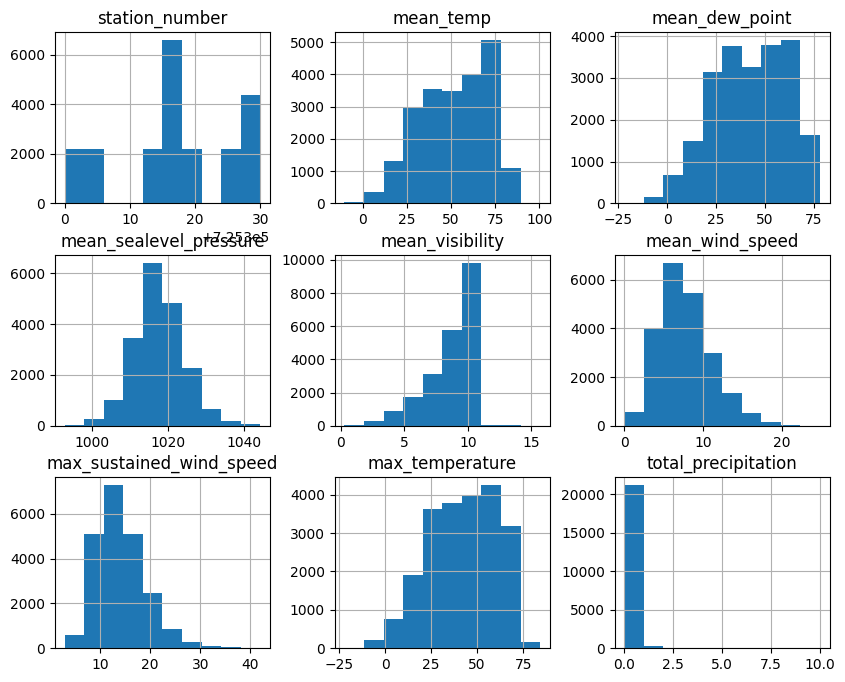

In [27]:
# plot feature distributions
df_small.hist(figsize=(10, 8),)
plt.show()

Some features have skewed distributions -> we add trying out transformations to the backlog.

In [28]:
# Want to create lag features, therefore include missing dates for all stations
df_small = df_small.groupby('station_number').apply(lambda df: df.set_index('date').asfreq('d'), include_groups=False).reset_index()
df_small.date = df_small.date.dt.date

In [29]:
# define lag features
lag_features = [
    'mean_temp',
    'mean_dew_point',
    'mean_sealevel_pressure',
    'mean_visibility',
    'mean_wind_speed',
    'max_sustained_wind_speed',
    'max_temperature',
    'total_precipitation',
]

In [30]:
# set number of lags
number_lags = 3

In [31]:
def assign_lag_value(df, feature: str, lag: int):
    """
    Add column with lagged feature values to the dataframe.
    """
    df[f"{feature}_lag_{lag}"] = df[feature].shift(lag)
    return df.reset_index(drop=True)

In [32]:
# create lag features
for feature in lag_features:
    for lag in range(1, number_lags + 1):
        df_small = df_small.groupby('station_number').apply(lambda df: assign_lag_value(df, feature, lag), include_groups=False)

In [33]:
df_small.reset_index(inplace=True)
df_small.drop(columns=['level_1'], inplace=True)

In [34]:
df_small.head()

,station_number,date,mean_temp,mean_dew_point,mean_sealevel_pressure,mean_visibility,mean_wind_speed,max_sustained_wind_speed,max_temperature,total_precipitation,...,mean_wind_speed_lag_3,max_sustained_wind_speed_lag_1,max_sustained_wind_speed_lag_2,max_sustained_wind_speed_lag_3,max_temperature_lag_1,max_temperature_lag_2,max_temperature_lag_3,total_precipitation_lag_1,total_precipitation_lag_2,total_precipitation_lag_3
0,725300,2000-01-01,38.400002,29.700001,1015.700012,9.8,6.8,13.0,26.100000,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,725300,2000-01-02,47.799999,42.299999,1006.400024,7.7,10.2,21.0,36.000000,0.01,...,NaN,13.0,NaN,NaN,26.100000,NaN,NaN,0.00,NaN,NaN
2,725300,2000-01-03,37.500000,34.099998,1011.099976,7.2,11.3,18.1,35.099998,0.01,...,NaN,21.0,13.0,NaN,36.000000,26.100000,NaN,0.01,0.00,NaN
3,725300,2000-01-04,29.700001,25.900000,1008.700012,7.0,12.3,19.0,26.100000,0.25,...,6.8,18.1,21.0,13.0,35.099998,36.000000,26.1,0.01,0.01,0.00
4,725300,2000-01-05,20.400000,16.500000,1025.199951,8.7,8.1,12.0,12.200000,0.00,...,10.2,19.0,18.1,21.0,26.100000,35.099998,36.0,0.25,0.01,0.01


In [35]:
# remove current day features
df_small.drop(columns=lag_features, inplace=True)

In [36]:
df_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21920 entries, 0 to 21919
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   station_number                  21920 non-null  Int64  
 1   date                            21920 non-null  object 
 2   snow                            21853 non-null  boolean
 3   mean_temp_lag_1                 21843 non-null  float64
 4   mean_temp_lag_2                 21833 non-null  float64
 5   mean_temp_lag_3                 21823 non-null  float64
 6   mean_dew_point_lag_1            21836 non-null  float64
 7   mean_dew_point_lag_2            21826 non-null  float64
 8   mean_dew_point_lag_3            21816 non-null  float64
 9   mean_sealevel_pressure_lag_1    19257 non-null  float64
 10  mean_sealevel_pressure_lag_2    19248 non-null  float64
 11  mean_sealevel_pressure_lag_3    19239 non-null  float64
 12  mean_visibility_lag_1           

In [37]:
# remove rows with NA values for target
df_small.dropna(subset=['snow'], inplace=True)

For now we omit cleaning missing feature values and use a classifier which handles them.

### 3. Task
Now it is time to split the data, into a training, evaluation and test set. As a reminder, the date we are trying to predict snow fall for should constitute your test set.

In [38]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [39]:
import datetime as dt

# str(dt.datetime.today()- dt.timedelta(days=20*365)).split(' ')[0]
test_date = (pd.to_datetime(dt.datetime.today().date()) - pd.DateOffset(years=20) + pd.DateOffset(days=1)).date()
print(test_date)


2005-05-15


In [40]:
# create train, validation and test set
df_test = df_small[df_small['date'] == test_date]
X_test = df_test.drop(columns=['snow', 'date'])
y_test = df_test['snow']

X = df_small[df_small['date'] != test_date].drop(columns=['snow', 'date'])
y = df_small[df_small['date'] != test_date]['snow']

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)

## Part 2
If you made it up to here all by yourself, you can use your prepared dataset to train an algorithm of your choice to forecast whether it will snow on the following date for each station in this dataset:

In [41]:
import datetime as dt

# str(dt.datetime.today()- dt.timedelta(days=20*365)).split(' ')[0]
test_date = (pd.to_datetime(dt.datetime.today().date()) - pd.DateOffset(years=20) + pd.DateOffset(days=1)).date()
print(test_date)

2005-05-15


You are allowed to use any library you are comfortable with such as sklearn, tensorflow, keras etc. 
If you did not manage to finish part one feel free to use the data provided in 'coding_challenge.csv' Note that this data does not represent a solution to Part 1. 

In [42]:
model = HistGradientBoostingClassifier(loss='log_loss', learning_rate=0.1, max_iter=100, max_leaf_nodes=31, max_depth=None, min_samples_leaf=10, random_state=42)

In [43]:
model.fit(X_train, y_train)

HistGradientBoostingClassifier(min_samples_leaf=10, random_state=42)

In [44]:
model.score(X_eval, y_eval)

0.8514534218356603

In [45]:
y_pred = model.predict(X_eval)

In [46]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91      3591
         1.0       0.62      0.42      0.50       778

    accuracy                           0.85      4369
   macro avg       0.75      0.68      0.71      4369
weighted avg       0.84      0.85      0.84      4369



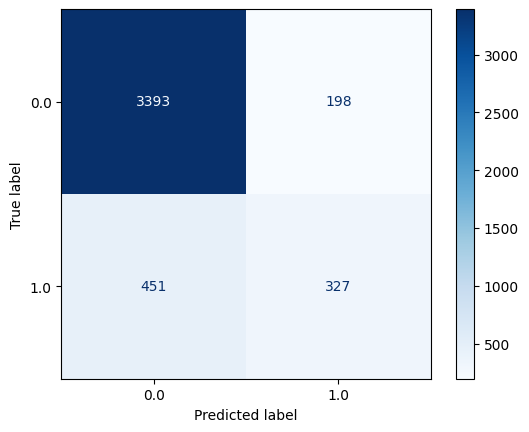

In [47]:
cm = confusion_matrix(y_eval, y_pred, labels=model.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm,
                        display_labels=model.classes_).plot(cmap=plt.cm.Blues)

We have an imbalanced dataset resulting in many false negatives. With more time, we could try different sampling techniques, train other models, test different features, optimize hyperparameters, etc. and then use the best model for the test set. Now we just evaluate the model on the test set.

In [48]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95        10
         1.0       0.00      0.00      0.00         0

    accuracy                           0.90        10
   macro avg       0.50      0.45      0.47        10
weighted avg       1.00      0.90      0.95        10



/Users/thibaudjoelhadamczik/git/snowfall-predict/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/thibaudjoelhadamczik/git/snowfall-predict/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/thibaudjoelhadamczik/git/snowfall-predict/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

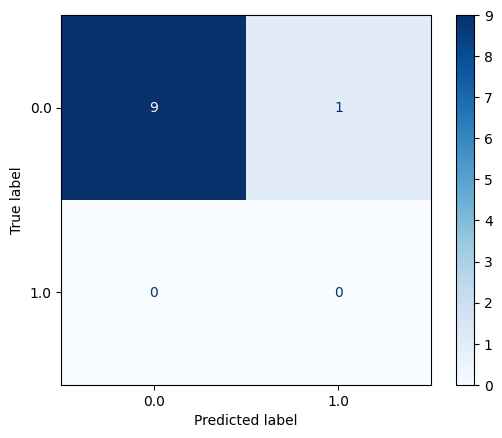

In [49]:
cm = confusion_matrix(y_test, model.predict(X_test), labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                        display_labels=model.classes_).plot(cmap=plt.cm.Blues)

Same problem as in the validation set.